<a href="https://colab.research.google.com/github/JustinMoon-exe/Eng-Fair-2020/blob/main/Copy_of_EngFairv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import csv    
from PIL import Image, ImageFilter

In [ ]:
!mkdir /root/.kaggle
!echo '{"username":"masterfushi","key":"d0f9a8618f87e8ed0d524187356ad495"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip \*.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
data = pd.read_csv("sign_mnist_train.csv")
print(data.shape)

FileNotFoundError: ignored

In [ ]:
x = data.iloc[:, 1:].values
y = data.iloc[:, :1].values.flatten()

In [ ]:
def one_hot_encode(y):
    return np.eye(25)[y]
y_encoded = one_hot_encode(y)
print('Shape of y after encoding:', y_encoded.shape)

Shape of y after encoding: (27455, 25)


In [ ]:
learning_rate = 0.001
epochs = 2000
batch_size = 128
display_step = 100
n_input = 784
n_classes = 25
dropout = 0.75

In [ ]:
X = tf.placeholder(tf.float32, shape = [None, n_input], name="X") # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes], name="Y") # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate
weights = {
    # Weight for Convolutional Layer 1: 5x5 filter, 1 input channel, 32 output channels
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # Weight for Convolutional Layer 2: 5x5 filter, 32 input channels, 64 output channels
    'w2' : tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # Weight for Fully Connected Layer 1: 49 * 64 input channels, 1024 output channels
    'w3' : tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # Weight for Convolutional Layer 1: 1024 input channels, 25(number of classes) output channels
    'w4' : tf.Variable(tf.random_normal([1024, n_classes]))
}
biases = {
    # Bias for Convolutional Layer 1
    'b1' : tf.Variable(tf.random_normal([32])),
    # Bias for Convolutional Layer 2
    'b2' : tf.Variable(tf.random_normal([64])),
    # Bias for Fully Connected Layer 1
    'b3' : tf.Variable(tf.random_normal([1024])),
    # Bias for Outout Layer
    'b4' : tf.Variable(tf.random_normal([n_classes]))
}
# Wrapper function for creating a Convolutional Layer
def conv2d(x, W, b, strides = 1):
    x = tf.nn.conv2d(x, W, strides = [1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
# Wrapper function for creating a Pooling Layer
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding = 'SAME')
def neural_network(x, weight, bias, dropout):
    x = tf.reshape(x, shape = [-1, 28, 28, 1])
    
    conv1 = conv2d(x, weight['w1'], bias['b1']) # Convolutional Layer 1
    conv1 = maxpool2d(conv1) # Pooling Layer 1
    
    conv2 = conv2d(conv1, weight['w2'], bias['b2']) # Convolutional Layer 1
    conv2 = maxpool2d(conv2) # Pooling Layer 1
    
    # Fully Connected Layer 1
    # Reshaping output of previous convolutional layer to fit the fully connected layer
    fc = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc = tf.add(tf.matmul(fc, weight['w3']), bias['b3']) # Linear Function
    fc = tf.nn.relu(fc) # Activation Function
    
    fc = tf.nn.dropout(fc, dropout) # Applying dropout on Fully Connected Layer
    
    out = tf.add(tf.matmul(fc, weight['w4']), bias['b4']) # Output Layer
    return out
logits = neural_network(X, weights, biases, keep_prob)
loss_op = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = Y)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.33, random_state = 42)
print('X train shape', X_train.shape)
print('y train shape', y_train.shape)
print('X test shape', X_test.shape)
print('y test shape', y_test.shape)

X train shape (18394, 784)
y train shape (18394, 25)
X test shape (9061, 784)
y test shape (9061, 25)


In [ ]:
def next_batch(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
def display_images(data):
    x, y = data
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(x[i].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(chr(y[i] + 65))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

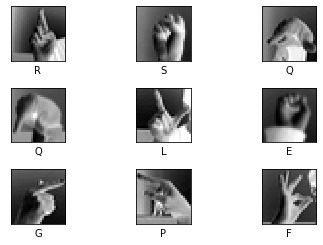

In [ ]:
display_images(next_batch(9, x, y))

In [ ]:
with tf.Session() as sess:
    # Running Initializer
    sess.run(init)
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, X_train, y_train)
        # Running Optimizer
        sess.run(train_op, feed_dict = { X : _x, Y : _y, keep_prob : dropout })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy], feed_dict = { X : _x, Y : _y, keep_prob : 1.0 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc*100)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy on Training Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : X_train,
                                                           Y : y_train,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    print('Accuracy on Test Data: ' + str(sess.run(accuracy,
                                                   feed_dict = {
                                                       X : X_test,
                                                       Y : y_test,
                                                       keep_prob : 1.0
                                                   }) * 100) + ' %')

Epoch 100, Cost: 124215591.625, Accuracy: 34.375 %
Epoch 200, Cost: 27972437.625, Accuracy: 68.75 %
Epoch 300, Cost: 8719844.5, Accuracy: 78.90625 %
Epoch 400, Cost: 8057232.25, Accuracy: 75.0 %
Epoch 500, Cost: 4141510.21875, Accuracy: 83.59375 %
Epoch 600, Cost: 1945596.90625, Accuracy: 89.84375 %
Epoch 700, Cost: 1859662.7890625, Accuracy: 90.625 %
Epoch 800, Cost: 1744056.421875, Accuracy: 89.0625 %
Epoch 900, Cost: 1172214.84375, Accuracy: 92.1875 %
Epoch 1000, Cost: 269439.09375, Accuracy: 97.65625 %
Epoch 1100, Cost: 660847.59375, Accuracy: 98.4375 %
Epoch 1200, Cost: 0.0, Accuracy: 100.0 %
Epoch 1300, Cost: 342277.1718761921, Accuracy: 97.65625 %
Epoch 1400, Cost: 547804.90625, Accuracy: 95.3125 %
Epoch 1500, Cost: 374965.1875, Accuracy: 99.21875 %
Epoch 1600, Cost: 58576.7421875, Accuracy: 99.21875 %
Epoch 1700, Cost: 0.0, Accuracy: 100.0 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 74830.875, Accuracy: 98.4375 %
Epoch 2000, Cost: 14393.75, Accuracy: 99.21875 %

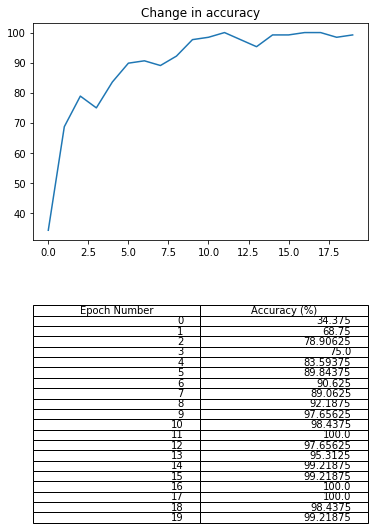

In [ ]:
collabels = ('Epoch Number', 'Accuracy (%)')
cellData = [[0, acc_hist[0]], [1, acc_hist[1]], [2, acc_hist[2]], [3, acc_hist[3]], [4, acc_hist[4]], [5, acc_hist[5]], [6, acc_hist[6]], [7, acc_hist[7]], [8, acc_hist[8]], [9, acc_hist[9]], [10, acc_hist[10]], [11, acc_hist[11]], [12, acc_hist[12]], [13, acc_hist[13]], [14, acc_hist[14]], [15, acc_hist[15]], [16, acc_hist[16]], [17, acc_hist[17]], [18, acc_hist[18]], [19, acc_hist[19]]]

plt.plot(list(range(len(acc_hist))), acc_hist)
plt.title("Change in accuracy")
plt.table(cellText=cellData, colLabels=collabels, loc='bottom', bbox=[0, -1.3, 1.0, 1.0])
plt.show()

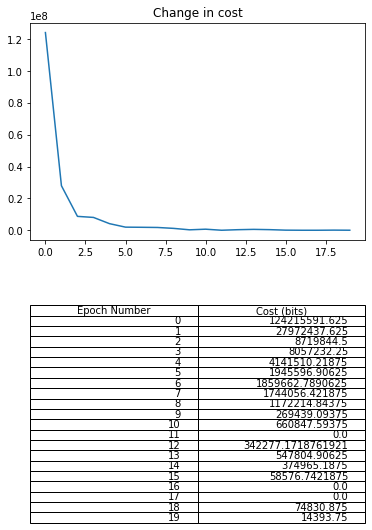

In [ ]:
costLabels = ('Epoch Number', 'Cost (bits)')
costData = [[0, cost_hist[0]], [1, cost_hist[1]], [2, cost_hist[2]], [3, cost_hist[3]], [4, cost_hist[4]], [5, cost_hist[5]], [6, cost_hist[6]], [7, cost_hist[7]], [8, cost_hist[8]], [9, cost_hist[9]], [10, cost_hist[10]], [11, cost_hist[11]], [12, cost_hist[12]], [13, cost_hist[13]], [14, cost_hist[14]], [15, cost_hist[15]], [16, cost_hist[16]], [17, cost_hist[17]], [18, cost_hist[18]], [19, cost_hist[19]]]

plt.plot(list(range(len(cost_hist))), cost_hist)
plt.title("Change in cost")
plt.table(cellText=costData, colLabels=costLabels, loc='bottom', bbox=[0, -1.3, 1.0, 1.0])
plt.show()

In [ ]:
eval_data = pd.read_csv("sign_mnist_test.csv")
print(eval_data.shape)

(7172, 785)


In [ ]:
eval_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [ ]:
x_test = eval_data.iloc[:, 1:].values
y_test = eval_data.iloc[:, :1].values.flatten()
y_test = one_hot_encode(y_test)
x_test.shape, y_test.shape

((7172, 784), (7172, 25))

In [ ]:
with tf.Session() as sess:
    sess.run(init) # Running Initializer
    cost_hist, acc_hist = [], []
    for epoch in range(1, epochs + 1):
        _x, _y = next_batch(batch_size, x, y_encoded)
        # Running Optimizer
        sess.run(train_op,
                 feed_dict = {
                     X : _x,
                     Y : _y,
                     keep_prob : dropout
                 })
        if epoch % display_step == 0:
            # Calculating Loss and Accuracy on the current Epoch
            loss, acc = sess.run([loss_op, accuracy],
                                 feed_dict = {
                                     X : _x,
                                     Y : _y,
                                     keep_prob : 1.0
                                 })
            loss = sum(loss)
            cost_hist.append(loss)
            acc_hist.append(acc)
            print('Epoch ' + str(epoch) + ', Cost: ' + str(loss) + ', Accuracy: ' + str(acc * 100) + ' %')
    print('-' * 50)
    print('\nOptimization Finished\n')
    print('Accuracy after training on whole dataset Data: ' + str(sess.run(accuracy,
                                                       feed_dict = {
                                                           X : x,
                                                           Y : y_encoded,
                                                           keep_prob : 1.0
                                                       }) * 100) + ' %')
    W = sess.run(weights)
    B = sess.run(biases)

Epoch 100, Cost: 113707691.625, Accuracy: 42.96875 %
Epoch 200, Cost: 35849317.0, Accuracy: 63.28125 %
Epoch 300, Cost: 12047997.25, Accuracy: 75.0 %
Epoch 400, Cost: 7598185.15625, Accuracy: 82.03125 %
Epoch 500, Cost: 5396444.25, Accuracy: 88.28125 %
Epoch 600, Cost: 1149292.8125, Accuracy: 93.75 %
Epoch 700, Cost: 1601166.28125, Accuracy: 92.1875 %
Epoch 800, Cost: 954229.59375, Accuracy: 96.09375 %
Epoch 900, Cost: 51872.5625, Accuracy: 98.4375 %
Epoch 1000, Cost: 0.0, Accuracy: 100.0 %
Epoch 1100, Cost: 0.0, Accuracy: 100.0 %
Epoch 1200, Cost: 0.0, Accuracy: 100.0 %
Epoch 1300, Cost: 175078.3125, Accuracy: 98.4375 %
Epoch 1400, Cost: 0.0, Accuracy: 100.0 %
Epoch 1500, Cost: 0.0, Accuracy: 100.0 %
Epoch 1600, Cost: 0.0, Accuracy: 100.0 %
Epoch 1700, Cost: 129225.0625, Accuracy: 99.21875 %
Epoch 1800, Cost: 0.0, Accuracy: 100.0 %
Epoch 1900, Cost: 0.0, Accuracy: 100.0 %
Epoch 2000, Cost: 133799.625, Accuracy: 99.21875 %
--------------------------------------------------

Optimizatio

In [ ]:
X = tf.placeholder(tf.float32, shape = [None, n_input]) # Placeholder for Feature Matrix
Y = tf.placeholder(tf.float32, shape = [None, n_classes]) # Placeholder for Labels
keep_prob = tf.placeholder(tf.float32) # Placeholder for Dropout Rate
y_pred = neural_network(X, W, B, 1.0)

In [ ]:
def get_prediction(img):
    with tf.Session() as sess:
        pred = sess.run(y_pred, feed_dict = { X : img, keep_prob : 1.0 })
    img = img.reshape(28, 28) #takes resolution of image and rescales it to 28X28 to help improve speeds and simplifiy the calculations
    pred = list(pred.flatten())
    pred = chr(pred.index(max(pred)) + 65)
    return (img, pred)

In [ ]:
word = ""

for i in range(5):
  randind = random.randrange(0, len(x_test))
  image, pred = get_prediction(x_test[randind].reshape(1, 784))
  plt.imshow(image, cmap = 'binary')
  #plt.title("Predicted value: " + pred)
  plt.show()
  word = word + pred

print(word)

NameError: ignored

In [ ]:
for key in W.keys():
    np.save(key, W[key])
for key in B.keys():
    np.save(key, B[key])